In [3]:
# @title Prepare Environment
import torch
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

#!pip install torch-scatter
!pip install torch-geometric
!pip install nystrom-attention
!pip install tensorboard
!git clone https://github.com/andrea-grandi/bio_project
!cd bio_project

2.5.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.8 MB/s eta 0:00:0000:01
Cloning into 'bio_project'...
remote: Enumerating objects: 11882, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 11882 (delta 19), reused 30 (delta 11), pack-reused 11829 (from 5)
Receiving objects: 100% (11882/11882), 757.87 MiB | 41.44 MiB/s, done.
Resolving deltas: 100% (1024/1024), done.
Updating files: 100% (3861/3861), done.


In [4]:
# @title Load Libraries
from torch_geometric.data import Dataset
import glob
from torch_geometric.data import data
from torch_geometric.loader import DataLoader
import sys
sys.path.append("/kaggle/working/bio_project/src/bio_project")
import argparse
import wandb
from torch.nn import BCEWithLogitsLoss
import torch
import os
import wandb
from argparse import Namespace
import time
import tqdm

In [5]:
data_root="/kaggle/input/embeddings-v4/final_embeddings_v3/processed"

In [6]:
# @title Dataset
class CustomDataset(Dataset):
    def __init__(self,root,data_type):
        self.path=os.path.join(root,data_type,"*")
        self.data=glob.glob(self.path)
        self.slides=[torch.load(self.data[idx]) for idx in range(len(self.data))]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.slides[idx]
        return sample
        
train_dataset=CustomDataset(data_root,"train")
test_dataset=CustomDataset(data_root,"test")
train_loader=DataLoader(train_dataset,batch_size=1,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=1,shuffle=True)

<ipython-input-6-d7b681704474>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.slides=[torch.load(self.data[idx]) for idx in range(len(self.data))]


In [7]:
from utils.test import test
from models import selectModel

In [8]:
# @title General Parser
def get_args():
    parser = argparse.ArgumentParser(description='Train Buffermil')

    # Optimization arguments
    group1 = parser.add_argument_group("optimization")
    group1.add_argument('--lr', default=0.001,
                        type=float, help='learning rate')
    group1.add_argument('--weight_decay', default=0.0001,
                        type=float, help='Weight decay [5e-3]')

    # GNN arguments
    group2 = parser.add_argument_group("gnn")
    group2.add_argument('--residual', default=False, action="store_true",)
    group2.add_argument('--num_layers', default=1, type=int,
                        help='number of Graph layers')
    group2.add_argument('--dropout', default=True, action="store_true")
    group2.add_argument('--dropout_rate', default=0.2, type=float)
    group2.add_argument('--layer_name', default="GAT",
                        type=str, help='layer graph name')
    group2.add_argument('--heads', default=2, type=int,
                        help='layer graph name')

    # Training arguments
    group3 = parser.add_argument_group("training")
    group3.add_argument('--seed', default=12, type=int,
                        help='seed for reproducibility')
    group3.add_argument('--n_epoch', default=100,
                        type=int, help='number of epochs')

    # Dimensions arguments
    group4 = parser.add_argument_group("dimensions")
    group4.add_argument('--n_classes', default=1, type=int,
                        help='Number of output classes [2]')
    group4.add_argument('--c_hidden', default=256,
                        type=int, help='intermediate size ')
    group4.add_argument('--input_size', default=384,
                        type=int, help='input size ')

    # Dataset arguments
    group5 = parser.add_argument_group("dataset")
    group5.add_argument('--scale', default="0", type=str,
                        help='scale resolution')
    group5.add_argument('--dataset', default="cam", type=str,
                        choices=["cam", "lung"], help='input size ')
    group5.add_argument('--datasetpath',  type=str, help='dataset path')

    # Distillation arguments
    group6 = parser.add_argument_group("distillation")
    group6.add_argument('--lamb', default=1, type=float, help='lambda')
    group6.add_argument('--beta', default=1, type=float, help='beta')
    group6.add_argument('--temperature', default=1.5, type=float, help='temperature')
    group6.add_argument('--add_bias', default=True, action="store_true")
    group6.add_argument('--max', default=True, action="store_true")
    group6.add_argument('--checkpoint', default=None, type=str, help='checkpoint')

    parser.add_argument('--tag', default="split", type=str, help='train strategy')
    parser.add_argument('--modeltype', default="Buffermil", type=str, help='train strategy')
    parser.add_argument('--project', default="bio_project", type=str, help='project name for wandb')
    parser.add_argument('--model', default="bio_project", type=str, help='project name for wandb')
    parser.add_argument('--wandbname', default="main", type=str, help='project name for wandb')

    group7 = parser.add_argument_group("submitit")
    group7.add_argument('--partition', default="prod",type=str,help='partition name')
    group7.add_argument('--time', default=120, type=float, help='job duration')
    group7.add_argument('--nodes', default=1, type=int, help='number of jobs')
    group7.add_argument('--job_name', default="dasmil",type=str,help="job name")
    group7.add_argument('--mem', default=32, type=int, help='ram requested GB')
    group7.add_argument('--job_parallel', default=10, type=int, help='number of jobs in parallel')
    group7.add_argument('--logfolder', default="logfolder", type=str, help='log folder location name')

    # Buffermil parameters
    group8 = parser.add_argument_group("submitit")
    group8.add_argument("--randomstore", default=False, help="ramdom sampling during the buffer storage")
    group8.add_argument("--bufferaggregate", default="mean", choices=["mean","max","diffmax"], help="type of buffer aggregation")
    group8.add_argument("--ntop", default=10, help="number of patches stored in the buffer per each image")
    group8.add_argument('--buffer_freq', default=10, type=int, help='frequency to update the buffer')
    
    filtered_args = [arg for arg in sys.argv if not arg.startswith('-f')]
    args = parser.parse_args(filtered_args[2:])
    return args

In [9]:
args = get_args()
print(args)

Namespace(lr=0.001, weight_decay=0.0001, residual=False, num_layers=1, dropout=True, dropout_rate=0.2, layer_name='GAT', heads=2, seed=12, n_epoch=100, n_classes=1, c_hidden=256, input_size=384, scale='0', dataset='cam', datasetpath=None, lamb=1, beta=1, temperature=1.5, add_bias=True, max=True, checkpoint=None, tag='split', modeltype='Buffermil', project='bio_project', model='bio_project', wandbname='main', partition='prod', time=120, nodes=1, job_name='dasmil', mem=32, job_parallel=10, logfolder='logfolder', randomstore=False, bufferaggregate='mean', ntop=10, buffer_freq=10)


In [52]:
# @title Select Model
import ipywidgets as widgets
from IPython.display import display

# Crea un menu a discesa
dropdown = widgets.Dropdown(
    options=["Buffermil", "CustomBuffermil", "CustomBuffermilV2"],
    value='CustomBuffermilV2',
    description='Choose:',
)

# Mostra il widget
display(dropdown)

# Recupera il valore selezionato
def on_value_change(change):
    print(f"Selected: {change['new']}")

dropdown.observe(on_value_change, names='value')
args.modeltype = dropdown.value

Dropdown(description='Choose:', index=2, options=('Buffermil', 'CustomBuffermil', 'CustomBuffermilV2'), value=…

In [53]:
model = selectModel(args)
model.kl = None

model CustomBuffermilV2
error loading state dict
error loading
Number of parameters: 347266
Memory usage: 0.044143104 GB


In [54]:
print(model)

CustomBuffermilV2(
  (mil): MILNetBuffer(
    (i_classifier): FCLayer(
      (fc): Sequential(
        (0): Linear(in_features=384, out_features=1, bias=True)
      )
    )
    (b_classifier): BClassifierBuffer(
      (lin): Sequential(
        (0): Linear(in_features=384, out_features=384, bias=True)
        (1): ReLU()
      )
      (q): Sequential(
        (0): Linear(in_features=384, out_features=128, bias=True)
        (1): Tanh()
      )
      (v): Sequential(
        (0): Dropout(p=0.0, inplace=False)
        (1): Linear(in_features=384, out_features=384, bias=True)
      )
      (fcc): Conv1d(1, 1, kernel_size=(384,), stride=(1,))
    )
  )
  (gate_layer): Sequential(
    (0): Linear(in_features=3, out_features=384, bias=True)
    (1): Sigmoid()
  )
)


In [55]:
# @title Training Method
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

results_test = []

def train(model, train_loader, test_loader, args, bufferaggregate, ntop):
    # Initialize wandb run
    #run = wandb.init(project="bio_project_v9", name=args.modeltype)

    epochs = args.n_epoch
    wd = args.weight_decay
    lr = args.lr
    model.train()
    model = model.cuda()
    loss_module_instance = BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.9), weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    
    # Test the initial model
    with torch.no_grad():
        start_test = time.time()
        metrics = test(model, testloader=test_loader)
        end_test = time.time()
        avg_score_higher_test, avg_score_lower_test, auc_value_higher_test, auc_value_lower_test, predictions, _, labels, precision, recall = metrics

        """
        wandb.log({
            "acc_higher_test": avg_score_higher_test,
            "acc_lower_test": avg_score_lower_test,
            "auc_higher_test": auc_value_higher_test,
            "epoch": -1,
            "lr": scheduler.get_last_lr()[0]
        })
        """
        
    BestPerformance = 0
    # Start training
    for idx, epoch in tqdm.tqdm(enumerate(range(epochs)), desc="epochs"):
        start_training = time.time()
        if hasattr(model, "preloop"):
            model.preloop(epoch, train_loader)

        # Iterate over the training data
        for _, data in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            data = data.cuda()
            x, edge_index, childof, level = data.x, data.edge_index, data.childof, data.level
            
            # Check if additional edge indices are present
            if data.__contains__("edge_index_2") and data.__contains__("edge_index_3"):
                edge_index2, edge_index3 = data.edge_index_2, data.edge_index_3
            else:
                edge_index2 = None
                edge_index3 = None

            try:
                results = model(x, edge_index, level, childof, edge_index2, edge_index3)
            except Exception as e:
                print(f"Error in forward pass: {e}")
                continue
                
            bag_label = data.y.float()
            loss = model.compute_loss(loss_module_instance, results, bag_label)
            #print(f"Loss: {loss}")
            #wandb.log({"loss": loss})
            loss.backward(retain_graph=True)
            optimizer.step()

        end_training = time.time()
        scheduler.step()
        start_test = time.time()
        metrics = test(model, testloader=test_loader)
        end_test = time.time()
        avg_score_higher_test, avg_score_lower_test, auc_value_higher_test, auc_value_lower_test, predictions, _, labels, precision, recall = metrics
        #avg_score_higher_test, avg_score_lower_test, auc_value_higher_test, auc_value_lower_test, predictions, _, labels = metrics

        #precision = precision_score(labels, predictions)
        #recall = recall_score(labels, predictions)
        #results_test = {'acc': avg_score_higher_test, 'auc': auc_value_higher_test, 'pre': precision, 'rec': recall}

        results_test.append({
            'config': f"{bufferaggregate}-{ntop}",
            'acc': avg_score_higher_test,
            'auc': auc_value_higher_test,
            'pre': precision,
            'rec': recall
        })

        if auc_value_higher_test > BestPerformance:
            BestPerformance = auc_value_higher_test
            torch.save(model.state_dict(), f"best_model_epoch_{epoch}.pt")
            print(f"✅ Miglior modello salvato all'epoca {epoch} con AUC {auc_value_higher_test:.4f}")
            #results_test = {'config': f"{bufferaggregate}-{ntop}", 'acc': avg_score_higher_test, 'auc': auc_value_higher_test, 'pre': precision, 'rec': recall}

        #print(f"acc_higher_test: {avg_score_higher_test}, acc_lower_test: {avg_score_lower_test}, auc_higher_test: {auc_value_higher_test}, epoch: {epoch}, lr: {scheduler.get_last_lr()[0]}")
        """
        wandb.log({
            "acc_higher_test": avg_score_higher_test,
            "acc_lower_test": avg_score_lower_test,
            "auc_higher_test": auc_value_higher_test,
            "epoch": epoch,
            "lr": scheduler.get_last_lr()[0]
        })
        """

    return results_test
    #wandb.finish()
    #return pd.DataFrame(results_test, index=range(len(results)))

In [56]:
train(model, train_loader, test_loader, args)

TypeError: train() missing 2 required positional arguments: 'bufferaggregate' and 'ntop'

Training con ntop=10, bufferaggregate=max


epochs: 1it [00:00,  2.34it/s]

✅ Miglior modello salvato all'epoca 0 con AUC 0.6209


epochs: 4it [00:01,  2.40it/s]

✅ Miglior modello salvato all'epoca 3 con AUC 0.6429


epochs: 9it [00:03,  2.26it/s]

✅ Miglior modello salvato all'epoca 8 con AUC 0.6703


epochs: 11it [00:05,  1.64it/s]

✅ Miglior modello salvato all'epoca 10 con AUC 0.7692


epochs: 21it [00:12,  1.44it/s]

✅ Miglior modello salvato all'epoca 20 con AUC 0.8187


epochs: 22it [00:13,  1.44it/s]

✅ Miglior modello salvato all'epoca 21 con AUC 0.8297


epochs: 100it [01:08,  1.47it/s]


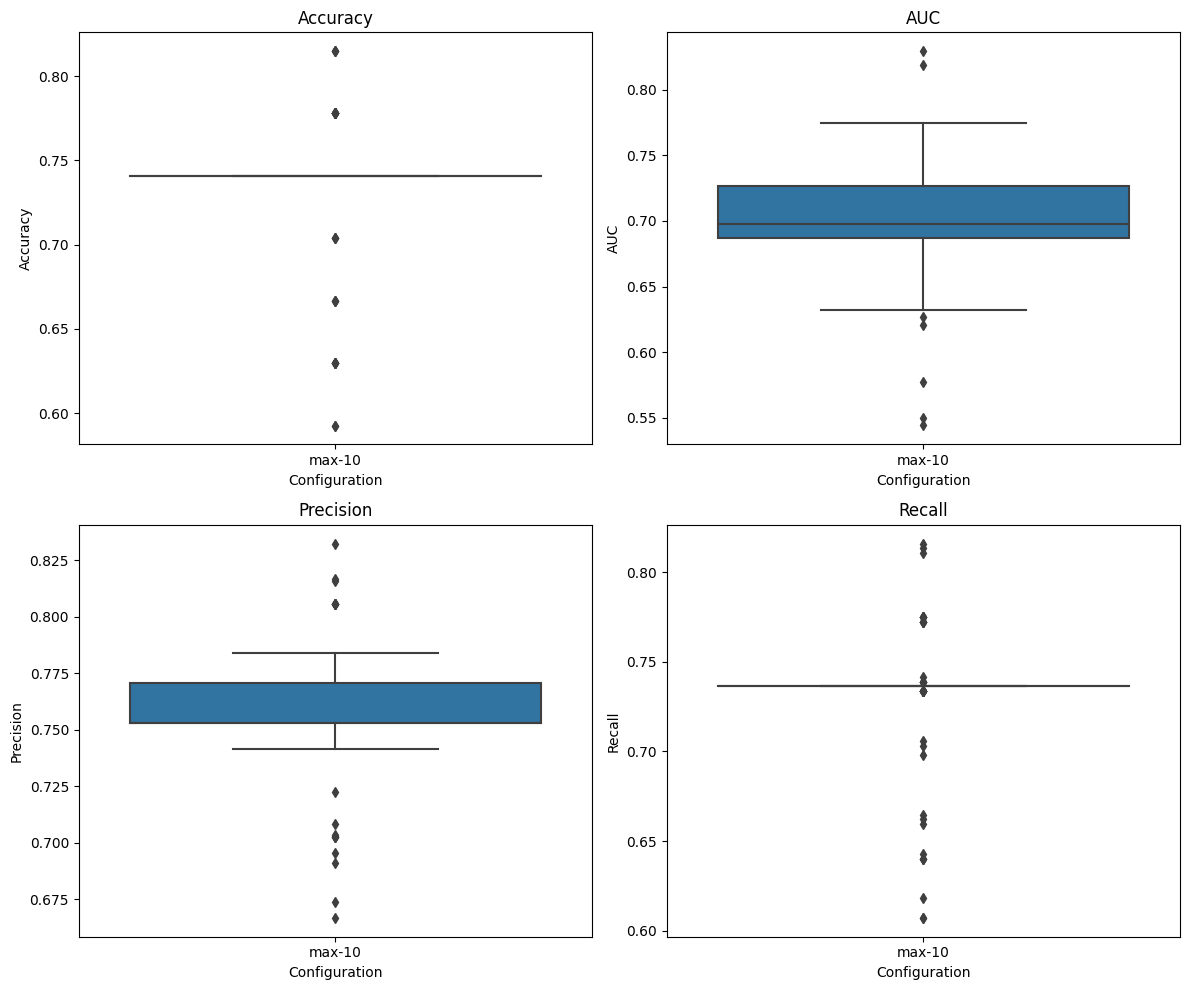

In [57]:
# @title Start Training
combinations = [
    ("max", 10)
]

results = []
config = []
acc = []
auc = []
rec = []
pre = []

def run_multiple_trainings(model, train_loader, test_loader, base_args):
    global results
    
    for bufferaggregate, ntop in combinations:
        args = base_args
        args.bufferaggregate = bufferaggregate
        args.ntop = ntop
        
        print(f"Training con ntop={ntop}, bufferaggregate={bufferaggregate}")
        out = train(model, train_loader, test_loader, args, bufferaggregate, ntop)
        results.append(out)
        #print(results)
        
run_multiple_trainings(model, train_loader, test_loader, args)
#print(results)

df = pd.DataFrame(results[0])

# Imposta la figura con 4 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
metrics = ['acc', 'auc', 'pre', 'rec']
titles = ['Accuracy', 'AUC', 'Precision', 'Recall']

# Crea i boxplot per ogni metrica
for i, ax in enumerate(axes.flat):
    sns.boxplot(x='config', y=metrics[i], data=df, ax=ax)
    ax.set_title(titles[i])
    ax.set_xlabel('Configuration')
    ax.set_ylabel(titles[i])

plt.tight_layout()
plt.show()


In [13]:
#wandb.login(key="d350c1926691a1f8b36ff558c9a28e9425f84fde")